# Network creation & Analysis

### <span style="color:teal">Creating nodes and edges for the network</span>

From the csv files created in the previous notebook(check 02.ipynb), we will be creating a node list and edge list <br>to use as input for creating a netowork representation using netowrkX.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### <span style="color:teal">Helper Functions</span>

In [4]:
def remove_nan_empty_rows(dataframe):
    dataframe.replace('', np.nan, inplace=True)
    dataframe.dropna(inplace=True)
    dataframe.dropna(how='all', inplace=True)
    dataframe.dropna(subset=dataframe.columns.values.tolist(), how='all', inplace=True)
    dataframe.dropna(subset=dataframe.columns.values.tolist(), how='any', inplace=True)
    dataframe.replace(np.nan, '', inplace=True)
    
    return dataframe

#removing self-loops from the edge list dataframe
def remove_selfloop(df, column1, column2):
    # Drop rows where the values in column1 and column2 are equal
    df = df[df[column1] != df[column2]]

    # Reset the index of the dataframe
    df = df.reset_index(drop=True)

    return df

#adding nodes from node_list
def add_nodes_from_dataframe(df):
    # Create an empty graph
    G = nx.DiGraph()

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        # Extract the node name from the row
        node_name = row['video ID']   #this could be the vide ID in our case

        # Extract the attributes from the row (excluding the 'Node' column)
        attributes = row.drop('video ID').to_dict()   

        # Add the node with its attributes to the graph
        G.add_node(node_name, **attributes)

    return G

#adding edges from edge_list
def edges_from_df(df,graph):
    
    g_nodes = set(graph.nodes())

    set2 = set(list(graph.nodes))
    for idx,row in tqdm(df.iterrows()):
        source = row[0]
        target = row[1]
        #print(source,target) this works just fine
        set1 = {source,target}
        is_proper_subset = set1.issubset(set2) and set1 != set2
        if is_proper_subset:
            graph.add_edges_from([(source,target)])
        else:
            continue
    return graph

# writing a function for graph creation
def create_Digraph(df_nlist,df_elist):
    #step 1 - declare the graph variable
    G = nx.DiGraph()
    
    #step 2 - add nodes from the nlist
    G = add_nodes_from_dataframe(df_nlist)
    
    #step 3 - check for orpahn nodes
    G = edges_from_df(df_elist,G)
    
    #step 4 - remove all orpahn nodes
    orphan_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
    print(len(orphan_nodes),' orphan nodes removed')
    
    return G

# function to export .gexf file for gephi
def export(graph_var,name):
    if '.gexf.gz' in name: 
        nx.write_gexf(graph_var,name)
    else:
        print('enter a name with file type as `.gexf.gz`')

### <span style="color:teal">Data Import and Preparation</span>

Now we importe the network data from the CSVs we created earlier.

In [9]:
# Importing the edge lists

eList1 = pd.read_csv("eList1.csv",delimiter=',',low_memory=False)
eList2 = pd.read_csv("eList2.csv",delimiter=',',low_memory=False)

In [10]:
len(eList1)  # length after import -> 15,41,415

1541415

In [13]:
# now we process the edge list dataframes so that they are ready to used for the graph creator function

# removing nan/ NaN and other such values
eList1 = remove_nan_empty_rows(eList1)
# removing self-loops 
eList1 = remove_selfloop(eList1, '0', '1')
# removing duplicates
eList1.drop_duplicates(inplace=True)

In [14]:
len(eList1) # length after cleaning -> 14,70,158

1470158

In [15]:
# lets do the same cleaning for the second edge list from 2008
len(eList2) # length after import -> 21,90,420

2190420

In [16]:
# removing nan/ NaN and other such values
eList2 = remove_nan_empty_rows(eList2)
# removing self-loops 
eList2 = remove_selfloop(eList2, '0', '1')
# removing duplicates
eList2.drop_duplicates(inplace=True)

In [17]:
len(eList2) # length after cleaning -> 15,33,099

1533099

Certain decisions were made after much trail and error with the data, the following steps are a result of those trails.

For example, we will be choosing only half the the edges from the edge lists to keep the network graph managable for computation at later stages. The choice of selecting which nodes to keep and which to drop is completly aribitrary as the dataframe is not sorted in any sense except maybe time they were crawled through by the web scrapper.

Similar approach is taken for the node list.

In [38]:
# Select half of the dataframe for 2007 edge list
sub7 = eList1.head(int(len(eList1)/2))
sub8 = eList2.head(int(len(eList2)/2))

In [21]:
# Importing the node lists with the attribute data
NL7 = pd.read_csv("S_data07.csv",delimiter=',',low_memory=False)
NL8 = pd.read_csv("S_data08.csv",delimiter=',',low_memory=False)

In [22]:
len(NL7) # length after import -> 3,84,474

384474

In [40]:
# cleaning the node list
NL7 = remove_nan_empty_rows(NL7)
# selecting half the node list
NL7_1 = NL7.head(int(len(NL7)/2))
NL7_2 = NL7.tail(int(len(NL7)/2))
len(NL7_1) # 1,90,206
len(NL7_2) # 1,90,206

190206

In [24]:
len(NL8) # length after import -> 4,97,246

497246

In [42]:
# cleaning the node list
NL8 = remove_nan_empty_rows(NL8)
# selecting half the node list
NL8_1 = NL8.head(int(len(NL8)/2))
NL8_2 = NL8.tail(int(len(NL8)/2))
len(NL8_1) # 2,48,350
len(NL8_2) # 2,48,350

248350

## Making the graph 

Making the graph for the april 2007 now, we will be storing it in the variable called `g1`

In [43]:
g1 = nx.DiGraph()
g1 = add_nodes_from_dataframe(NL7_1)
g1 = edges_from_df(eList1,g1)

1470158it [00:32, 45828.75it/s]


In [44]:
# check the node and edge count
print("Number of nodes:", g1.number_of_nodes())  # 1,90,206
print("Number of edges:", g1.number_of_edges())  # 1,90,877

Number of nodes: 190206
Number of edges: 190877


In [45]:
# now we remove the orphan nodes from this graph
# 1 - Find orphan nodes
orphan_nodes = [node for node in g1.nodes() if g1.in_degree(node) == 0 and g1.out_degree(node) == 0]
print(len(orphan_nodes))
# 2 - remove orphan nodes
g1.remove_nodes_from(orphan_nodes)

81963


In [46]:
# check the node and edge count
print("Number of nodes:", g1.number_of_nodes())  # 1,08,243
print("Number of edges:", g1.number_of_edges())  # 1,90,877

Number of nodes: 108243
Number of edges: 190877


<hr>
Making the graph for the april 2008 now, we will be storing it in the variable called `g2`

In [47]:
g2 = nx.DiGraph()
g2 = add_nodes_from_dataframe(NL8_1)
g2 = edges_from_df(eList2,g2)

1533099it [00:35, 43692.19it/s]


In [48]:
# check the node and edge count
print("Number of nodes:", g2.number_of_nodes())  # 2,48,350
print("Number of edges:", g2.number_of_edges())  # 2,66,613

Number of nodes: 248350
Number of edges: 266613


In [49]:
# now we remove the orphan nodes from this graph
# 1 - Find orphan nodes
orphan_nodes = [node for node in g2.nodes() if g2.in_degree(node) == 0 and g2.out_degree(node) == 0]
print(len(orphan_nodes))
# 2 - remove orphan nodes
g2.remove_nodes_from(orphan_nodes)

102861


In [51]:
# check the node and edge count
print("Number of nodes:", g2.number_of_nodes())  # 1,45,489
print("Number of edges:", g2.number_of_edges())  # 2,66,613

Number of nodes: 145489
Number of edges: 266613


### <span style="color:teal">Doing some basic analysis of the network's structure</span>

We will be conducting some basic measurements to understand the nature of the network before going for specific analysis. First we take the network graph for the year 2007 - that is `g1`.

In [172]:
def diameter_directed(G):
    # Get strongly connected components
    components = nx.strongly_connected_components(G)

    # Calculate the maximum diameter among components
    max_diameter = 0
    for component in components:
        component_graph = G.subgraph(component)
        diameter = nx.diameter(component_graph)
        if diameter > max_diameter:
            max_diameter = diameter

    print("Network Diameter:", max_diameter)

In [253]:
print("Density:", nx.density(g1))
diameter_directed(g1)
print("Reciprocity:", nx.reciprocity(g1))
print("Average in-degree:", sum(dict(g1.in_degree()).values()) / g1.number_of_nodes())
print("Average out-degree:", sum(dict(g1.out_degree()).values()) / g1.number_of_nodes())
print("Assortativity coefficient:", nx.degree_assortativity_coefficient(g1))
print("Transitivity:", nx.transitivity(g1))
print("Number of strongly connected components:", nx.number_strongly_connected_components(g1))  #output - 2,79,984
print("Number of weakly connected components:", nx.number_weakly_connected_components(g1)) # output - 23,818
print(nx.is_directed_acyclic_graph(g1))

Density: 1.629138368411498e-05
Network Diameter: 20
Reciprocity: 0.2669886890510643
Average in-degree: 1.7634119527359737
Average out-degree: 1.7634119527359737
Assortativity coefficient: 0.30243865280017784
Transitivity: 0.47550274445530777
Number of strongly connected components: 89797
Number of weakly connected components: 13786
False


Now we perform the same measurement on the second graph from 2008 and see how much it has changed.

In [254]:
print("Density:", nx.density(g2))
diameter_directed(g2)  # gephi shows the network diameter as 64 but networkX shows 43
print("Reciprocity:", nx.reciprocity(g2))
print("Average in-degree:", sum(dict(g2.in_degree()).values()) / g2.number_of_nodes())
print("Average out-degree:", sum(dict(g2.out_degree()).values()) / g2.number_of_nodes())
print("Assortativity coefficient:", nx.degree_assortativity_coefficient(g2))
print("Transitivity:", nx.transitivity(g2))
print("Number of strongly connected components:", nx.number_strongly_connected_components(g2))  #output - 2,79,984
print("Number of weakly connected components:", nx.number_weakly_connected_components(g2)) # output - 23,818
print(nx.is_directed_acyclic_graph(g2))

Density: 1.2595748751694415e-05
Network Diameter: 43
Reciprocity: 0.373642695592488
Average in-degree: 1.8325302943865172
Average out-degree: 1.8325302943865172
Assortativity coefficient: 0.17740002030236565
Transitivity: 0.25977746433781446
Number of strongly connected components: 101261
Number of weakly connected components: 10175
False


### <span style="color:teal">Showing Power Law in the graph</span>

We can try to do this WRT to two things, <br>
1 - in-degree of the nodes in the graph <br>
2 - the local clustering coefficient of the nodes <br>
3 - connected components size <br>

/var/folders/yq/sryk517930l66t3h_fdc8w040000gn/T/ipykernel_56198/2292542113.py:18: RuntimeWarning: divide by zero encountered in power
  y = (x ** (-2)) / (sum(degree_values) ** (-2))


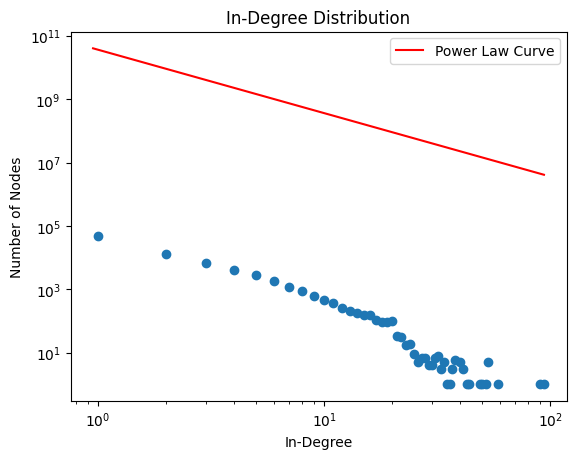

In [122]:
# Calculate the in-degree for each node
in_degrees = dict(g1.in_degree())

# Get the in-degree values and corresponding counts
degree_values = list(in_degrees.values())
degree_counts = np.bincount(np.array(degree_values, dtype=int))

# Plot the in-degree distribution
plt.scatter(range(len(degree_counts)), degree_counts)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.title('In-Degree Distribution')

# Plot the power law curve
x = np.linspace(min(degree_values), max(degree_values), 100)
y = (x ** (-2)) / (sum(degree_values) ** (-2))
plt.plot(x, y, color='red', label='Power Law Curve')

plt.legend()
plt.show()

/var/folders/yq/sryk517930l66t3h_fdc8w040000gn/T/ipykernel_56198/1296064693.py:16: RuntimeWarning: divide by zero encountered in power
  y = (x ** (-2)) / (sum(degree_values) ** (-2))


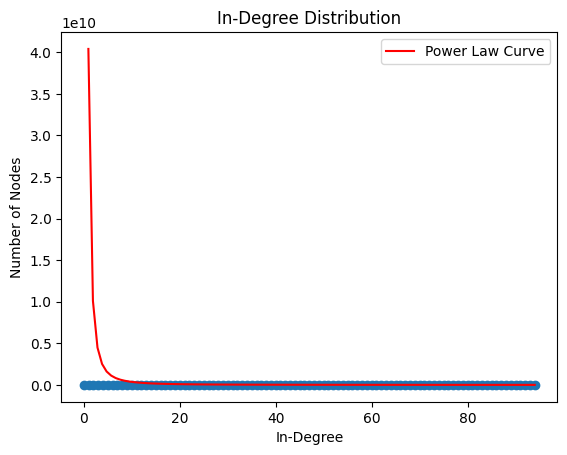

In [68]:
# Calculate the in-degree for each node
in_degrees = dict(g1.in_degree())

# Get the in-degree values and corresponding counts
degree_values = list(in_degrees.values())
degree_counts = np.bincount(np.array(degree_values, dtype=int))

# Plot the in-degree distribution
plt.scatter(range(len(degree_counts)), degree_counts)
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.title('In-Degree Distribution')

# Plot the power law curve
x = np.linspace(min(degree_values), max(degree_values), 100)
y = (x ** (-2)) / (sum(degree_values) ** (-2))
plt.plot(x,y, color='red', label='Power Law Curve')

plt.legend()
plt.show()

/var/folders/yq/sryk517930l66t3h_fdc8w040000gn/T/ipykernel_56198/2252498696.py:17: RuntimeWarning: divide by zero encountered in power
  y = (x ** (-2)) / (sum(degree_values) ** (-2))


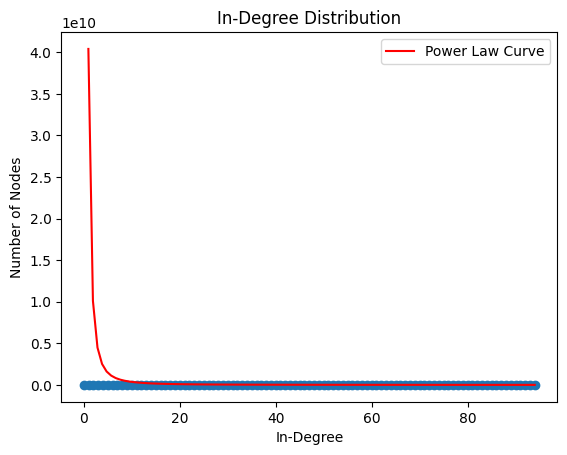

In [70]:
# Calculate the in-degree for each node
in_degrees = dict(g1.in_degree())

# Get the in-degree values and corresponding counts
degree_values = list(in_degrees.values())
degree_counts = np.bincount(np.array(degree_values, dtype=int))

# Plot the in-degree distribution
plt.scatter(range(len(degree_counts)), degree_counts)
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.title('In-Degree Distribution')

# Plot the power law curve if the sum of degree_values is not zero
if sum(degree_values) != 0:
    x = np.linspace(min(degree_values), max(degree_values), 100)
    y = (x ** (-2)) / (sum(degree_values) ** (-2))
    plt.plot(x, y, color='red', label='Power Law Curve')

plt.legend()
plt.show()

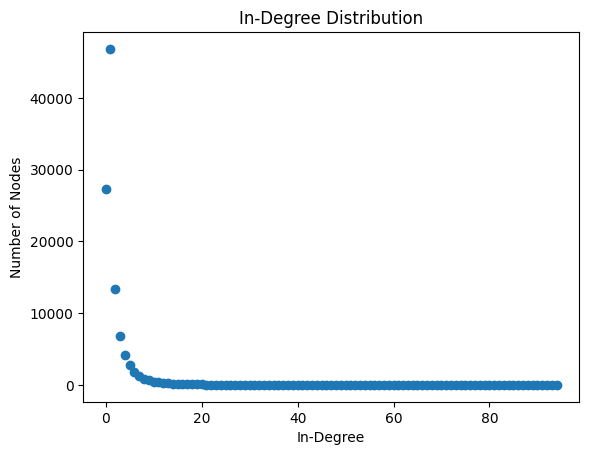

In [118]:
# Calculate the in-degree for each node in the graph
in_degrees = dict(g1.in_degree())

# Get the in-degree values and corresponding counts
degree_values = list(in_degrees.values())
degree_counts = np.bincount(np.array(degree_values, dtype=int))

# Plot the in-degree distribution
plt.scatter(range(len(degree_counts)), degree_counts)
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.title('In-Degree Distribution')

plt.show()

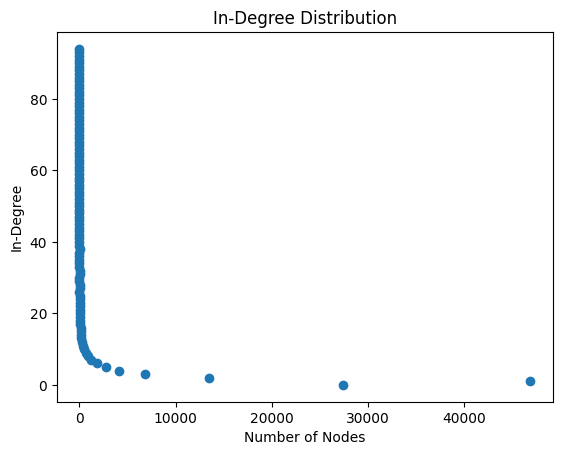

In [123]:
in_degrees = dict(g1.in_degree())
degree_values = list(in_degrees.values())
degree_counts = np.bincount(np.array(degree_values, dtype=int))

plt.scatter(degree_counts, range(len(degree_counts)))  # Flipped axis
plt.xlabel('Number of Nodes')
plt.ylabel('In-Degree')  # Flipped label
plt.title('In-Degree Distribution')

plt.show()

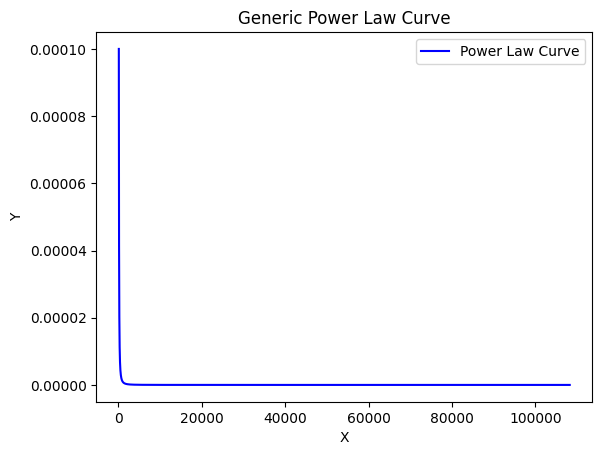

In [86]:
# Define the power law curve equation
exponent = -2
x_min = 100
x_max = len(g1.nodes)
num_points = len(g1.nodes)

x = np.linspace(x_min, x_max, num_points)
y = x ** exponent

# Plot the power law curve
plt.plot(x, y, color='blue', label='Power Law Curve')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generic Power Law Curve')
plt.legend()
plt.show()

### <span style="color:teal">Calculating the clustering co-efficient of each node, LCC</span>

In [149]:
#dfdf = pd.DataFrame({'Column1': datatest, 'Column2': datatest2})

In [162]:
# Calculate the local clustering coefficient (LCC)
def LCC(G):
    local_clustering = nx.clustering(G, nodes=G.nodes())

    # Store the local clustering coefficient in a dictionary
    clustering_coefficients = {}
    for node, clustering_coefficient in local_clustering.items():
        clustering_coefficients[node] = clustering_coefficient
        
    # Transferring the data from dictionary to dataframe
    K = []
    V = []
    for k,v in clusteringValues1.items():
        key = k
        value = clusteringValues1[k]
        K.append(key)
        V.append(value)
    
    df = pd.DataFrame({'node_ID': K, 'LCC': V})

    return df

In [163]:
LCC_df1 = LCC(g1)

In [256]:
# we can add this data to the node attribute csv to get better results in the visualisation
LCC_df1.head(8)
#LCC_df1.describe()

,node_ID,LCC
0,GEn9QkLAbC8,0.000000
1,ooQ2rVCsecA,0.000000
2,5k9zhok_iqo,0.000000
3,Rtr_GCfFzBI,0.000000
4,jxvetM7uqms,0.000000
5,Me82R7DKsMU,0.000000
6,zF6-RBTAs60,0.000000
7,DAKJagJqKtU,0.166667


In [262]:
# Calculate the in-degree for each node in the graph
in_degrees = dict(g1.in_degree())
lcc = LCC_df1['LCC']
lcc = list(lcc)

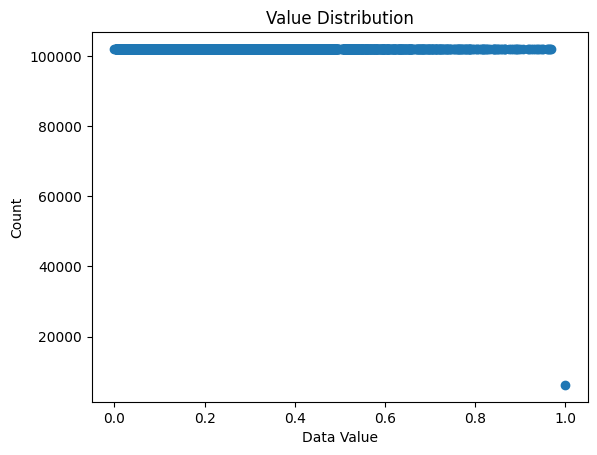

In [275]:
# Convert unique values to integers
unique_values = np.unique(lcc)
unique_values_int = np.array(unique_values, dtype=np.int64)

# Count the occurrences of each value
value_counts = np.bincount(np.array(lcc, dtype=np.int64))

# Plot the value distribution
plt.scatter(unique_values, value_counts[unique_values_int])
plt.xlabel('Data Value')
plt.ylabel('Count')
plt.title('Value Distribution')

plt.show()

### <span style="color:teal">Checking Isomorphism of two graphs</span>

In [183]:
test = nx.is_isomorphic(g1,g2)
print("Isomporgic graphs? - ",test)

test = nx.faster_could_be_isomorphic(g1,g2)
print("Isomporgic graphs? - ",test)

Isomporgic graphs? -  False
Isomporgic graphs? -  False


In [179]:
def clique_calc(graph):
    # Convert the directed graph to an undirected graph
    undirected_graph = graph.to_undirected()

    # Find all cliques in the undirected graph
    cliques = list(nx.find_cliques(undirected_graph))

    # Get the number of cliques
    num_cliques = len(cliques)

    print("Number of Cliques:", num_cliques)

In [180]:
clique_calc(g1) # output - 93,297

Number of Cliques: 93297


In [181]:
clique_calc(g2) # output - 1,42,788

Number of Cliques: 142788


### <span style="color:teal">Exporting the graphs</span>

In [56]:
export(g1,'g1.gexf.gz')

In [171]:
export(g2,'g2.gexf.gz')

In [ ]:
# the following code tries to summaries the graph?
'''
node_attributes = ('ratings',)
G1 = nx.snap_aggregation(g1,node_attributes)
'''

In [224]:
strong_components1 = list(nx.strongly_connected_components(g1))
strong_components1.sort(key=len,reverse=True)
strong_components2 = list(nx.strongly_connected_components(g2))
strong_components2.sort(key=len,reverse=True)

In [ ]:
# checking component isomorphism between the strongly connected components of the two network graphs
for i in range(89797):
    component_i = strong_components1[i]
    for j in range(100000): 
        component_j = strong_components2[j]
        #print(len(component_i),len(component_j))
        #is_isomorphic = nx.is_isomorphic(g1.subgraph(component_i), g2.subgraph(component_j))
        if len(component_i) == len(component_j) and len(component_i) > 7:
            #print("same length found")
            #undirected_graph = directed_graph.to_undirected()
            is_isomorphic = nx.is_isomorphic(g1.subgraph(component_i).to_undirected(), g2.subgraph(component_j).to_undirected())
            couldBe_isomorphic = nx.faster_could_be_isomorphic(g1.subgraph(component_i).to_undirected(), g2.subgraph(component_j).to_undirected())
            if is_isomorphic:
                print(len(component_i),len(component_j))
                print(is_isomorphic)

From the above code we can see that there are some strongly connected components which `could be` isomorphic. These components all have 8 nodes and that seems to be the limit till which the youtube algorithm keeps the videos is a ismoprphic state after that each component develops their own ido-syncracies we assume. 

If we converted the directed subgraphs into undirected graphs, then the number of isomorhpic components increase as well as the number of nodes in these components go up to 10 but that seems to be the limit there.

We also can find some case of `sure` isomorphism with upto 8 nodes in the the component.

In [294]:
def subgraph_category(graph,attribute,values):
   # Filter the subgraph based on a specific attribute value
    attribute_key = attribute
    attribute_values = values
    subgraph_nodes = [n for n, data in graph.nodes(data=True) if attribute_key in data and data[attribute_key] in attribute_values]
    subgraph = graph.subgraph(subgraph_nodes)


    # Print the nodes in the subgraph
    #print("Nodes in the subgraph:")
    #print(subgraph.nodes())
    
    # Print the length (number of nodes) in the subgraph
    subgraph_length = len(subgraph)
    print("Length of nodes in the subgraph:", subgraph_length)
    return subgraph

In [295]:
attri = 'category'
value1 = ['Entertainment','Music']
g1_enterainment = subgraph_category(g1,attri,value1)

subgraph_length = len(g1_enterainment)
print("Length of nodes in the subgraph:", subgraph_length)

Length of nodes in the subgraph: 46783
Length of nodes in the subgraph: 46783


In [296]:
export(g1_enterainment,'g1_entertainment.gexf.gz')